In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [45]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.spatial import distance
from sklearn import manifold

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_context('poster')

In [5]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
df = pd.read_pickle('CCPA.pkl.gz')

In [8]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [9]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

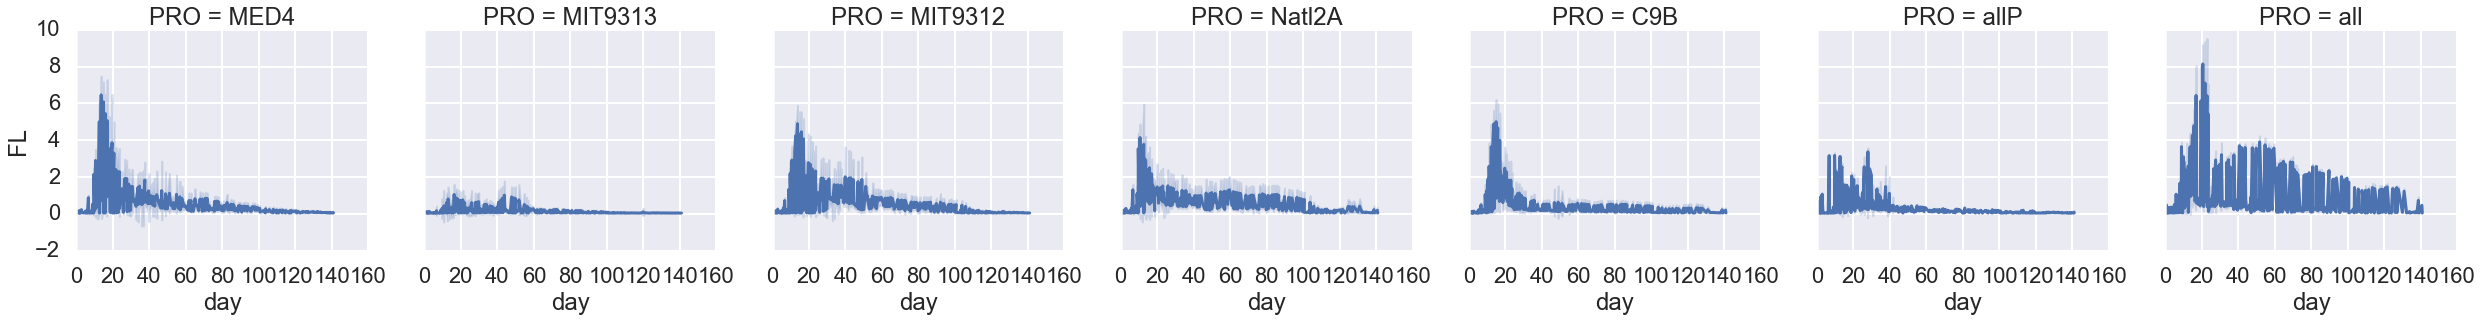

In [10]:
sns.relplot(data=df, x='day', y='FL', kind='line',  col='PRO', ci='sd')

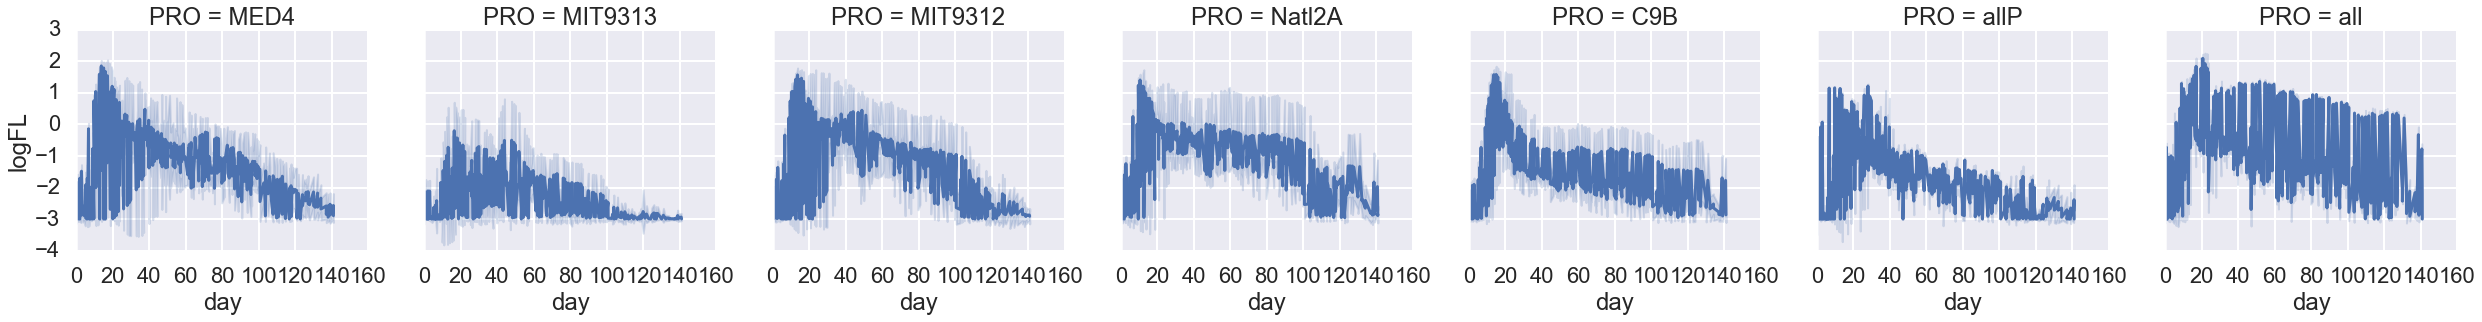

In [11]:
sns.relplot(data=df, x='day', y='logFL', kind='line',  col='PRO', ci='sd')

In [88]:
X = cp.experiments2X(df, sample_col='experiment_sample', cumsummode=False)
metadf = cp.get_meta(df)


In [89]:
X.head()

day,0.0,0.715972222,0.88,0.94,0.99,1.92,1.9256944440000001,2.03,2.6,2.83125,...,136.97,137.0,137.96,137.99,138.80833330000002,139.09,139.11,140.70833330000002,140.9,140.93
experiment_sample,,,,,,,,,,,,,,,,,,,,,
"e1, 10A",-2.813411,-2.343407,-2.285634,-2.264501,-2.246890,-1.919328,-1.917323,-1.897240,-1.787494,-1.742969,...,-1.406648,-1.404701,-1.342405,-1.340458,-1.287354,-1.326464,-1.329241,-1.551169,-1.551169,-1.551169
"e1, 10B",-2.975930,-2.488915,-2.394930,-2.360551,-2.331902,-1.799030,-1.795767,-1.822166,-1.966427,-2.024953,...,-1.608561,-1.607625,-1.577654,-1.576717,-1.551169,-1.522058,-1.519990,-1.354796,-1.354796,-1.354796
"e1, 10C",-2.718101,-2.198225,-2.174731,-2.166137,-2.158975,-2.025769,-2.024953,-2.011775,-1.939760,-1.910543,...,-1.702994,-1.700516,-1.621231,-1.618754,-1.551169,-1.547032,-1.546738,-1.523260,-1.523260,-1.523260
"e1, 11A",-1.890475,-2.216407,-2.150672,-2.126627,-2.106589,-1.733888,-1.731606,-1.695577,-1.498694,-1.418818,...,-2.945259,-2.946082,-2.972440,-2.973264,-2.995732,-2.966254,-2.964160,-2.796881,-2.796881,-2.796881
"e1, 11B",-1.698269,-2.055725,-2.008000,-1.990543,-1.975995,-1.705405,-1.703749,-1.669981,-1.485451,-1.410587,...,-2.908428,-2.909530,-2.944780,-2.945881,-2.975930,-2.928985,-2.925651,-2.659260,-2.659260,-2.659260


In [90]:
metadf.head()

,experiment_sample,experiment,sample,PRO,ALT,culture,FL
0,"e1, 10A",e1,10A,C9B,DE,Co_Culture,0.744932
1,"e1, 10B",e1,10B,C9B,DE,Co_Culture,0.801284
2,"e1, 10C",e1,10C,C9B,DE,Co_Culture,0.736932
3,"e1, 11A",e1,11A,MED4,DE1,Co_Culture,0.888864
4,"e1, 11B",e1,11B,MED4,DE1,Co_Culture,0.824534


In [91]:
D = distance.squareform(distance.pdist(X, lambda x,y: fastdtw(x, y, dist=euclidean)[0]))

In [98]:
mds = manifold.MDS(2, max_iter=100, n_init=1, dissimilarity='precomputed', metric=False)
trans_data = mds.fit_transform(D)



In [99]:
def run_pca(X, metadf, sample_col='experiment_sample', n_components=2):
    scaledX = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(scaledX)
    print('Variance percent explained\n', pca.explained_variance_ratio_)
    pca_columns = [f'PCA{i}' for i in range(1,n_components+1)]
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = pca_columns)
    principalDf.set_index(X.index, inplace=True)
    dfpca = pd.merge(left=principalDf, left_index=True, right=metadf, right_on=sample_col)
    return dfpca


In [100]:
sample_col='experiment_sample'
cols = [f'NMDS{i}' for i in range(2)]
principalDf = pd.DataFrame(data = trans_data
                 , columns = cols)
principalDf.set_index(X.index, inplace=True)
dfpca = pd.merge(left=principalDf, left_index=True, right=metadf, right_on=sample_col)

ValueError: c of shape (535,) not acceptable as a color sequence for x with size 535, y with size 535

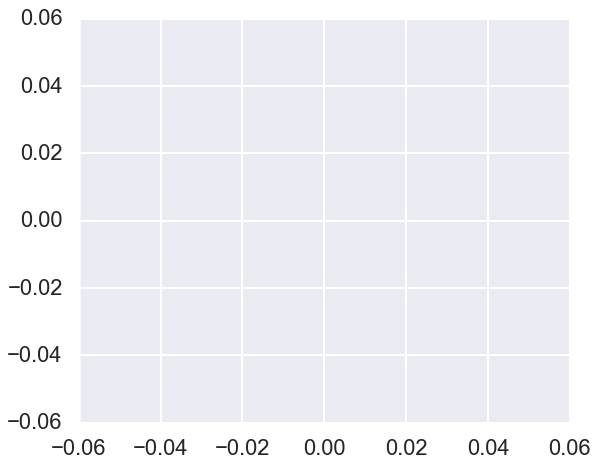

In [101]:
sns.relplot(data=dfpca, x='NMDS0', y='NMDS1', hue='PRO', 
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder,edgecolor=pedge,
           )


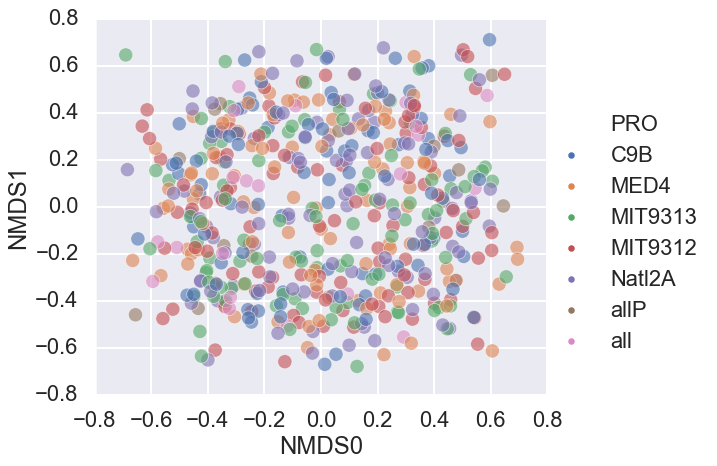

In [105]:
sns.relplot(data=dfpca, x='NMDS0', y='NMDS1', hue='PRO', 
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )


In [75]:
dfpca.head()

,NMDS0,NMDS1,experiment_sample,experiment,sample,PRO,ALT,culture,FL
0,0.308181,-0.001135,"e3, 11A",e3,11A,MED4,DE1,Co_Culture,0.567797
1,0.077336,0.400439,"e3, 11B",e3,11B,MED4,DE1,Co_Culture,0.519962
2,-0.278766,-0.474065,"e3, 11C",e3,11C,MED4,DE1,Co_Culture,0.544291
3,0.431286,-0.187279,"e3, 12A",e3,12A,MIT9313,DE1,Co_Culture,0.099835
4,-0.447789,-0.260595,"e3, 12B",e3,12B,MIT9313,DE1,Co_Culture,0.095025


In [96]:
D

array([[  0.        ,  28.56384445,  26.44917469, ..., 171.38906478,
        201.81856574, 164.68433031],
       [ 28.56384445,   0.        ,  32.74186173, ..., 160.11417868,
        180.82441587, 151.14077824],
       [ 26.44917469,  32.74186173,   0.        , ..., 134.18448602,
        122.42777149, 125.18267165],
       ...,
       [171.38906478, 160.11417868, 134.18448602, ...,   0.        ,
         86.17914394,  77.99215649],
       [201.81856574, 180.82441587, 122.42777149, ...,  86.17914394,
          0.        ,  58.83367713],
       [164.68433031, 151.14077824, 125.18267165, ...,  77.99215649,
         58.83367713,   0.        ]])

In [97]:
D.shape


(535, 535)

In [102]:
dfpca

,NMDS0,NMDS1,experiment_sample,experiment,sample,PRO,ALT,culture,FL
0,-0.456286,-0.040586,"e1, 10A",e1,10A,C9B,DE,Co_Culture,0.744932
1,-0.428845,0.054509,"e1, 10B",e1,10B,C9B,DE,Co_Culture,0.801284
2,0.146829,-0.284574,"e1, 10C",e1,10C,C9B,DE,Co_Culture,0.736932
3,-0.236614,-0.003142,"e1, 11A",e1,11A,MED4,DE1,Co_Culture,0.888864
4,0.130323,-0.399519,"e1, 11B",e1,11B,MED4,DE1,Co_Culture,0.824534
5,0.314264,0.081314,"e1, 11C",e1,11C,MED4,DE1,Co_Culture,0.898591
6,-0.380245,0.313979,"e1, 12A",e1,12A,MIT9313,DE1,Co_Culture,0.214659
7,-0.013411,-0.187012,"e1, 12B",e1,12B,MIT9313,DE1,Co_Culture,0.207386
8,0.113609,-0.072244,"e1, 12C",e1,12C,MIT9313,DE1,Co_Culture,0.226114
9,-0.168397,0.141560,"e1, 13A",e1,13A,MIT9312,DE1,Co_Culture,1.060545
